In [151]:
import numpy as np
from PIL import Image
from datetime import datetime
import os

def array_to_image(arr, show=False, save_path=None):
    """
    Chuyển NumPy array (float32, dạng [1, H, W] hoặc [H, W]) thành ảnh PIL.
    
    Parameters:
        arr (np.ndarray): Mảng đầu vào, giá trị float32 từ 0 đến 1.
        show (bool): Nếu True, hiển thị ảnh.
        save_path (str): Đường dẫn lưu ảnh nếu muốn, ví dụ: "output.png"
    
    Returns:
        PIL.Image.Image: Đối tượng ảnh PIL.
    """
    # Bỏ chiều dư thừa nếu có (ví dụ (1, H, W))
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = np.squeeze(arr, axis=0)

    # Chuẩn hóa về 0–255 và ép kiểu về uint8
    arr = (arr * 255).clip(0, 255).astype(np.uint8)

    # Tạo ảnh từ array
    img = Image.fromarray(arr)

    # Hiển thị ảnh nếu cần
    if show:
        img.show()

    # Tạo đường dẫn lưu nếu không cung cấp
    if save_path is None:
        now = datetime.now()
        timestamp = now.strftime("%Y%m%d_%H%M%S")
        filename = f"img_{timestamp}.png"
        save_path = os.path.join(os.getcwd(), filename)
    
    if save_path:
        img.save(save_path)

    return img


In [152]:
def build_filename(prefix, checkpoint_path, ext=".png"):
    # Lấy tên file checkpoint, bỏ phần đuôi .pt
    model_name = os.path.splitext(os.path.basename(checkpoint_path))[0]  # -> "sam2.1_hiera_large"

    # Tạo timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Kết hợp prefix + model name + timestamp
    filename = f"{prefix}_{model_name}_{timestamp}{ext}"
    return filename

# Zero-shot object detection pipeline

In [153]:
# from transformers import pipeline

In [154]:
checkpoint = "google/owlv2-base-patch16-ensemble"
# detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

In [155]:
# import skimage
# import numpy as np
# from PIL import Image

# image = skimage.data.astronaut()
# image = Image.fromarray(np.uint8(image)).convert("RGB")

# image

In [156]:
# predictions = detector(
#     image,
#     candidate_labels=["human face", "rocket", "nasa badge", "star-spangled banner"],
# )
# predictions

In [157]:
# from PIL import ImageDraw

# draw = ImageDraw.Draw(image)

# for prediction in predictions:
#     box = prediction["box"]
#     label = prediction["label"]
#     score = prediction["score"]

#     xmin, ymin, xmax, ymax = box.values()
#     draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
#     draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")
    
# image

# Text-prompted zero-shot object detection by hand

## Tải mô hình owlv2

In [158]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

## Tải mô hình SAM2

In [159]:
# !git clone https://github.com/facebookresearch/sam2.git|

In [160]:
# !bash download_ckpts.sh

In [161]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./sam2/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2_model = build_sam2(model_cfg, checkpoint)
sam2_predictor = SAM2ImagePredictor(sam2_model)

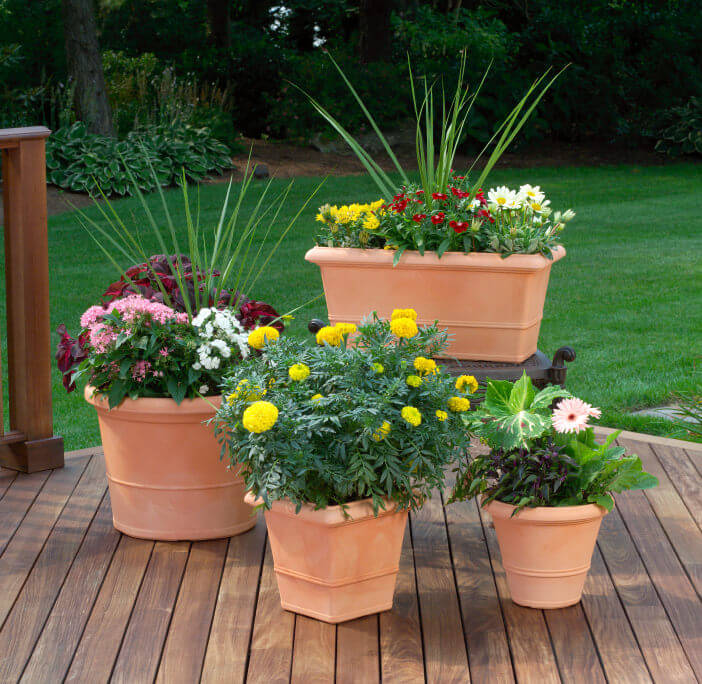

In [162]:
import requests

# url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
# url = "https://img.freepik.com/premium-photo/potted-plant_920207-9698.jpg"
url = "http://s3.amazonaws.com/homestratosphere/wp-content/uploads/2016/04/18214757/27patio-potted-plants.jpg"
ori_image = Image.open(requests.get(url, stream=True).raw)
ori_image

In [163]:
text_queries = ["potted", "plant"]
# the image processor resized images before feeding them to the model
inputs = processor(text=text_queries, images=ori_image, return_tensors="pt")

In [164]:
import torch
import copy
from PIL import ImageDraw
with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([ori_image.size[::-1]])
    # use the post_process_object_detection() method to make sure the predicted bounding boxes have the correct coordinates relative to the original image
    results = processor.post_process_grounded_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]


In [165]:
im = ori_image.copy()
draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="brown")
# im.show()

In [166]:

scores = results["scores"]
labels = results["labels"]
boxes = results["boxes"]

threshold = 0.2
valid_boxes = boxes[scores > threshold].cpu().numpy()
valid_labels = [text_queries[label] for label, score in zip(labels, scores) if score > threshold]

In [167]:
valid_labels

['plant', 'plant', 'potted', 'plant', 'potted', 'plant', 'potted', 'potted']

In [168]:
valid_boxes

array([[287.91467 ,  41.985867, 573.89667 , 269.0413  ],
       [ 52.46349 , 135.12164 , 328.02078 , 405.23532 ],
       [306.75418 , 243.5022  , 569.9116  , 362.58203 ],
       [212.00261 , 313.29828 , 479.65186 , 522.1305  ],
       [ 82.4957  , 380.81735 , 259.59537 , 542.61237 ],
       [447.96722 , 371.6993  , 657.8821  , 521.4543  ],
       [480.16428 , 488.71344 , 610.1751  , 609.64545 ],
       [258.97638 , 482.52942 , 416.79886 , 625.63837 ]], dtype=float32)

In [169]:
import numpy as np
import cv2

# Tải hình ảnh vào SAM 2
sam2_predictor.set_image(np.array(ori_image.convert("RGB")))

masks, scores, logits = sam2_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=valid_boxes,
    multimask_output=False,
)

In [170]:
import copy
from PIL import Image, ImageDraw

# Tạo bản sao ảnh
im = ori_image.copy()
draw = ImageDraw.Draw(im)

# Tạo layer mặt nạ rỗng
mask_layer = Image.new("RGBA", im.size, (0, 0, 0, 0))  # layer chứa các mask

for box, score, label, mask in zip(boxes, scores, labels, masks):
    # Vẽ bounding box
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin - 15), f"{text_queries[label]}: {round(score.item(), 2)}", fill="black")

    # Vẽ mặt nạ lên layer phụ
    mask = mask[0]  # (H, W)
    array_to_image(mask)
    mask_image = Image.fromarray((mask * 255).astype(np.uint8)).convert("L")
    mask_draw = ImageDraw.Draw(mask_layer)
    mask_draw.bitmap((0, 0), mask_image, fill=(0, 250, 0, 120))

# Gộp ảnh mask với ảnh chính
im = Image.alpha_composite(im.convert("RGBA"), mask_layer).convert("RGB")

# Hiển thị hoặc lưu
# im.show()
filename = build_filename("owlv2_sam2", checkpoint)
im.save(filename)
